In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
np.random.seed(17)
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split as tts
import seaborn as sns
from sklearn.metrics import r2_score as r2
%matplotlib inline

/Users/dyanni3/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [225]:
dat=np.random.normal(0,1,(10000,3))
dat[:,2]=dat[:,0]/dat[:,1]
Xtot=dat[:,:2]
ytot=dat[:,2]
df=pd.DataFrame(data=dat,columns=["x1","x2","y"])
train,test=tts(dat)
X=train[:,:2]
y=train[:,2]
Xtest=test[:,:2]
ytest=test[:,2]

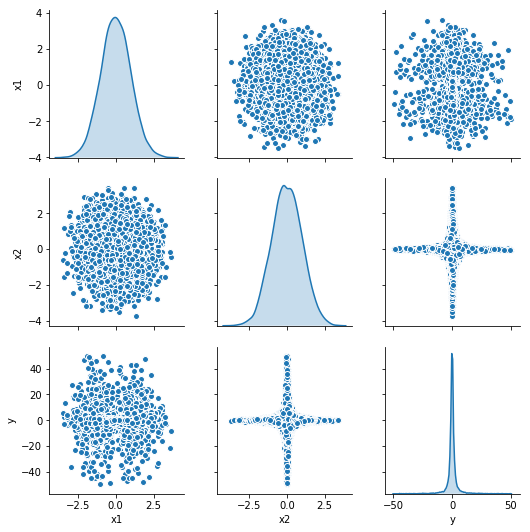

In [231]:
df_to_plot=df[abs(df['y'])<50]
sns.pairplot(df_to_plot,diag_kind='kde',diag_kws=dict(shade=True));

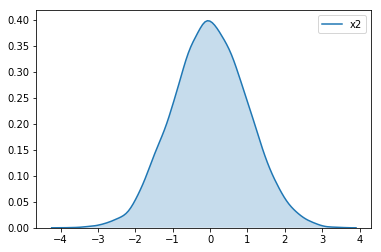

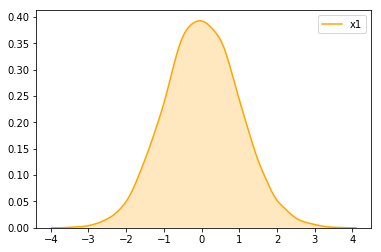

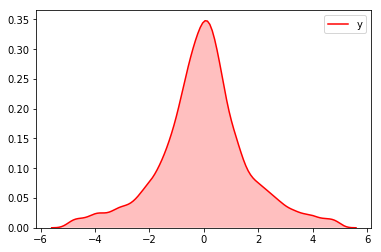

In [244]:
plt.figure()
sns.kdeplot(df['x2'],shade=True)
plt.figure()
sns.kdeplot(df['x1'],shade=True,color='orange')
plt.figure()
sns.kdeplot(df[abs(df['y'])<5]['y'],shade=True,color='red')

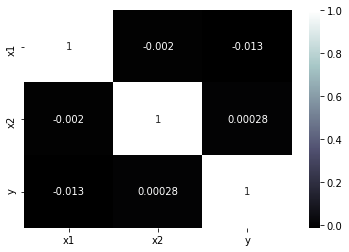

In [245]:
sns.heatmap(df.corr(),cmap=plt.cm.bone,annot=True)

# Power law fit

First going to fit a power-law because we know that will work (the data generating process is $y=\frac{x_1}{x_2}$.)

If $y=\prod{x_i^{\theta_i}}$, then $\log(y^2)=\sum{\theta_i \cdot log(x_i^2)}$ and so after taking the tranformations $y_t=\log(y^2)$ and $x_t=\log(x^2)$ we can just use linear regression to find the weights $\{\theta_i\}$

$y_t=\sum{\theta_i \cdot x_{t,i}}$


The weights $\{\theta_i\}$ can be solved directly by $\vec{\theta}=\big(\textbf{X}_t^T \textbf{X}_t\big)^{-1} \textbf{X}_t^T \vec{y}_t$, same as in a linear regression

In [198]:
class PowerLaw:
    def fit(self,X,y):
        X=np.log(X**2)
        y=np.log(y**2)
        self.thetas=np.linalg.inv(X.T@ X)@ X.T @ y
    def predict(self,X):
        return np.prod(X**self.thetas,axis=1)

[ 1. -1.]
Power law R^2: 1.0


/Users/dyanni3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


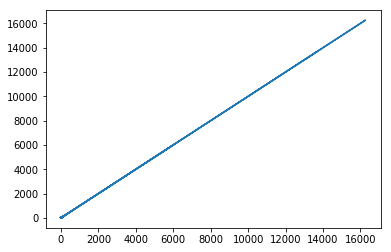

In [199]:
power=PowerLaw()
power.fit(X,y)
powerpred=power.predict(Xtest)
plt.plot(powerpred,ytest)
print(power.thetas)
print("Power law R^2: "+str(r2(powerpred[~np.isnan(powerpred)],ytest[~np.isnan(powerpred)])))

# Linear Models

We know these are going to fail since the function we hope to learn is not linear! Anyway just going through the motions

Linear Regression R^2: -4159.145544066275


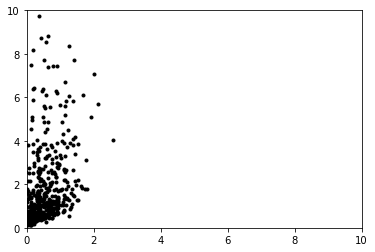

In [228]:
linreg=LR()
linreg.fit(X,y)
lin_pred=linreg.predict(X)
lin_test=linreg.predict(Xtest)
plt.plot(lin_test,ytest,'k.')
plt.xlim(0,10)
plt.ylim(0,10)
print("Linear Regression R^2: "+str(r2(lin_test,ytest)))

ridge regression R^2: -0.0005726352661314937


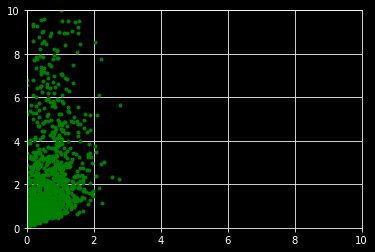

In [229]:
ridge=Ridge(alpha=1)
ridge.fit(X,y)
print("ridge regression R^2: "+str(ridge.score(Xtest,ytest)))
ridge_pred=ridge.predict(X)
ridge_test=ridge.predict(Xtest)
with plt.style.context('dark_background'):
    plt.plot(ridge_pred, y,'g.')
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.grid()

# Polynomial model

Polynomial Regression R^2: -782.0298731483782


<BarContainer object of 10 artists>

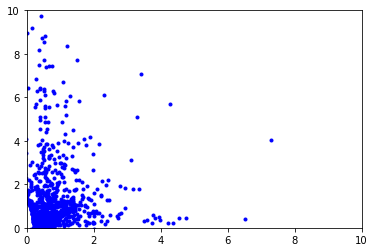

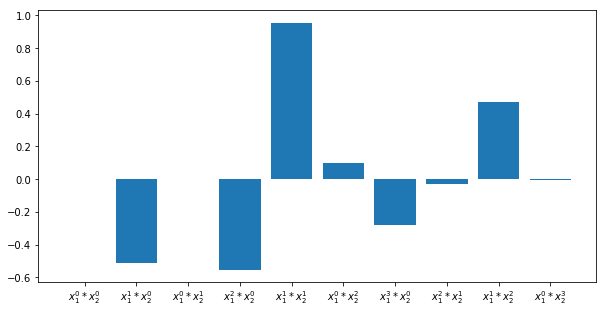

In [246]:
#generate polynomial features up to cubic
poly=PF(3)
Xp=poly.fit_transform(X)
linreg.fit(Xp,y)
poly_pred=linreg.predict(Xp)
Xptest=poly.transform(Xtest)
poly_test=linreg.predict(Xptest)
plt.plot(poly_test,ytest,'b.')
plt.xlim(0,10)
plt.ylim(0,10)
print("Polynomial Regression R^2: "+str(r2(poly_test,ytest)))
linreg.coef_
names=[]
for row in poly.powers_:
    names.append(r"$x_1^%d*x_2^%d$"%(row[0],row[1]))
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(names)),linreg.coef_,tick_label=names)

# Neural networks

I don't really know much (anything) about neural networks, but going to just use some 'out of the box' NN from Keras to give this a try. I imagine there are specific architectures and initializations etc. that one ought to use if trying to learn a simple function, but ...

In [276]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [277]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [278]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=150, batch_size=5, verbose=0)

In [168]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

In [169]:
kfold = KFold(n=X.shape[0],n_folds=4, random_state=7)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyboardInterrupt: 

In [279]:
history=estimator.fit(X,y,epochs=20)

dict_keys(['loss'])


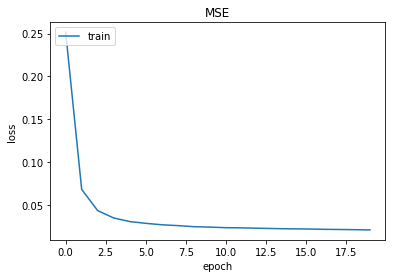

In [280]:
print(history.history.keys())
plt.plot(history.history['loss'])
#plt.plot(history.history['val_acc'])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [281]:
nn_pred=estimator.predict(X)
nn_test=estimator.predict(Xtest)

NN R^2: 0.890775806598


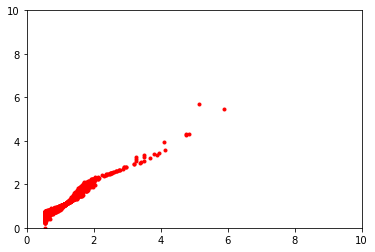

In [282]:
plt.plot(nn_test,ytest,'r.')
plt.xlim(0,10)
plt.ylim(0,10)
print("NN R^2: "+str(r2(nn_test,ytest)))

In [283]:
# define the model
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(10, input_dim=2, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	return model

In [284]:
# evaluate model with standardized dataset
deepNN = KerasRegressor(build_fn=larger_model, nb_epoch=5, batch_size=5, verbose=2)

In [118]:
history=deepNN.fit(Xtot,ytot,validation_split=.25,epochs=200)

Train on 7500 samples, validate on 2500 samples
Epoch 1/200
 - 6s - loss: 4.6175 - acc: 0.0000e+00 - val_loss: 8.3061 - val_acc: 0.0000e+00
Epoch 2/200
 - 5s - loss: 4.4406 - acc: 0.0000e+00 - val_loss: 8.2899 - val_acc: 0.0000e+00
Epoch 3/200
 - 5s - loss: 4.4252 - acc: 0.0000e+00 - val_loss: 8.2841 - val_acc: 0.0000e+00
Epoch 4/200
 - 5s - loss: 4.4195 - acc: 0.0000e+00 - val_loss: 8.2838 - val_acc: 0.0000e+00
Epoch 5/200
 - 5s - loss: 4.4133 - acc: 0.0000e+00 - val_loss: 8.2826 - val_acc: 0.0000e+00
Epoch 6/200
 - 5s - loss: 4.4057 - acc: 0.0000e+00 - val_loss: 8.2788 - val_acc: 0.0000e+00
Epoch 7/200
 - 5s - loss: 4.3991 - acc: 0.0000e+00 - val_loss: 8.2758 - val_acc: 0.0000e+00
Epoch 8/200
 - 5s - loss: 4.3961 - acc: 0.0000e+00 - val_loss: 8.2730 - val_acc: 0.0000e+00
Epoch 9/200
 - 5s - loss: 4.3946 - acc: 0.0000e+00 - val_loss: 8.2733 - val_acc: 0.0000e+00
Epoch 10/200
 - 5s - loss: 4.3874 - acc: 0.0000e+00 - val_loss: 8.2695 - val_acc: 0.0000e+00
Epoch 11/200
 - 6s - loss: 4.39

dict_keys(['acc', 'val_acc', 'loss', 'val_loss'])


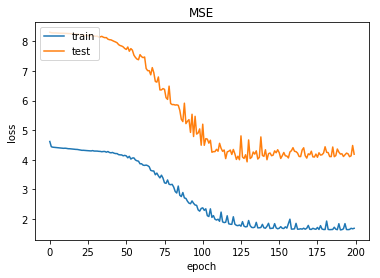

In [119]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [285]:
deepNN.fit(X,y,epochs=100)
deep_nn_pred=deepNN.predict(X)
deep_nn_test=deepNN.predict(Xtest)

Epoch 1/100
 - 5s - loss: 0.1922 - acc: 0.0000e+00
Epoch 2/100
 - 5s - loss: 0.0410 - acc: 0.0000e+00
Epoch 3/100
 - 5s - loss: 0.0311 - acc: 0.0000e+00
Epoch 4/100
 - 5s - loss: 0.0270 - acc: 0.0000e+00
Epoch 5/100
 - 5s - loss: 0.0248 - acc: 0.0000e+00
Epoch 6/100
 - 5s - loss: 0.0233 - acc: 0.0000e+00
Epoch 7/100
 - 5s - loss: 0.0231 - acc: 0.0000e+00
Epoch 8/100
 - 5s - loss: 0.0220 - acc: 0.0000e+00
Epoch 9/100
 - 5s - loss: 0.0216 - acc: 0.0000e+00
Epoch 10/100
 - 5s - loss: 0.0212 - acc: 0.0000e+00
Epoch 11/100
 - 5s - loss: 0.0211 - acc: 0.0000e+00
Epoch 12/100
 - 5s - loss: 0.0207 - acc: 0.0000e+00
Epoch 13/100
 - 5s - loss: 0.0201 - acc: 0.0000e+00
Epoch 14/100
 - 5s - loss: 0.0204 - acc: 0.0000e+00
Epoch 15/100
 - 5s - loss: 0.0199 - acc: 0.0000e+00
Epoch 16/100
 - 5s - loss: 0.0190 - acc: 0.0000e+00
Epoch 17/100
 - 5s - loss: 0.0192 - acc: 0.0000e+00
Epoch 18/100
 - 5s - loss: 0.0185 - acc: 0.0000e+00
Epoch 19/100
 - 5s - loss: 0.0194 - acc: 0.0000e+00
Epoch 20/100
 - 5s - 

deep NN R^2: 0.994551476814


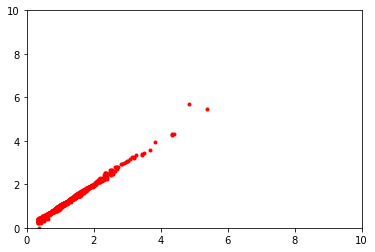

In [289]:
plt.plot(deep_nn_test,ytest,'r.')
plt.xlim(0,10)
plt.ylim(0,10)
print("deep NN R^2: "+str(r2(deep_nn_test,ytest)))

# Support vector machine

SVR R^2: -100226.85711166765


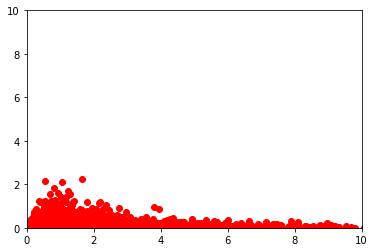

In [134]:
from sklearn.svm import SVR
svm=SVR()
#svm=SVR(kernel='poly',degree=3)
svm.fit(X,y)
svm_pred=svm.predict(X)
svm_pred_test=svm.predict(Xtest)
plt.plot(y,svm_pred,'ro')
plt.xlim(0,10)
plt.ylim(0,10)
print("SVR R^2: "+str(r2(svm_pred_test,ytest)))

# Decision tree regressor 

### (seriously?)

(0, 10)

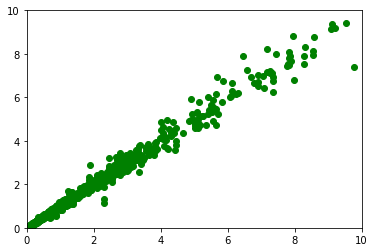

In [129]:
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor(max_depth=500)
tree.fit(X,y)
tree_pred=tree.predict(X)
tree_test=tree.predict(Xtest)
plt.plot(tree_test,ytest,'go')
plt.xlim(0,10)
plt.ylim(0,10)

In [136]:
from sklearn.metrics import r2_score
#print(r"training R^2 deepNN: "+str(r2_score(y,deep_nn_pred)))
print(r"training R^2 polynomial regression: "+str(r2_score(y,poly_pred)))
#print(r"training R^2 NN: "+str(r2_score(y,nn_pred)))
print(r"training R^2 linear regression: "+str(r2_score(y,lin_pred)))
print(r"training R^2 ridge regression: "+str(r2_score(y,ridge_pred)))
print(r"training R^2 support vector machine: "+str(r2_score(y,svm_pred)))
print(r"training R^2 decision tree regressor: "+str(r2_score(y,tree_pred)))
print(r"training R^2 tree ensemble: "+str(r2_score(y,regr2_pred)))
print(r"training R^2 random forest: "+str(r2_score(y,forest_pred)))


training R^2 polynomial regression: 0.00039756474444596623
training R^2 linear regression: 5.653748123324309e-05
training R^2 ridge regression: 5.65270897403547e-05
training R^2 support vector machine: -0.00012574158055711493
training R^2 decision tree regressor: 0.9999999999998339
training R^2 tree ensemble: 0.9999999999998339
training R^2 random forest: 0.8994053842910784


In [137]:
#print(r"test R^2 deepNN: "+str(r2_score(ytest,deep_nn_test)))
print(r"test R^2 polynomial regression: "+str(r2_score(ytest,poly_test)))
#print(r"test R^2 NN: "+str(r2_score(ytest,nn_test)))
print(r"test R^2 linear regression: "+str(r2_score(ytest,lin_test)))
print(r"test R^2 ridge regression: "+str(r2_score(ytest,ridge_test)))
print(r"test R^2 support vector machine: "+str(r2_score(ytest,svm_pred_test)))
print(r"test R^2 decision tree regressor: "+str(r2_score(ytest,tree_test)))
print(r"test R^2 tree ensemble: "+str(r2_score(ytest,regr2_test)))
print(r"test R^2 random forest: "+str(r2_score(ytest,forest_test)))

test R^2 polynomial regression: 0.002383815436478476
test R^2 linear regression: 0.0005299855094397232
test R^2 ridge regression: 0.0005223826610801785
test R^2 support vector machine: 3.0271254224056854e-05
test R^2 decision tree regressor: 0.11607401958475694
test R^2 tree ensemble: 0.11607401958475694
test R^2 random forest: 0.17689858542197623


(0, 10)

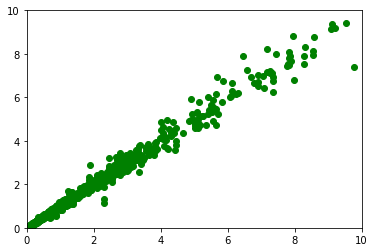

In [132]:
from sklearn.ensemble import AdaBoostRegressor

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=500),
                          n_estimators=300)

regr_2.fit(X,y)

regr2_pred=tree.predict(X)
regr2_test=tree.predict(Xtest)
plt.plot(regr2_test,ytest,'go')
plt.xlim(0,10)
plt.ylim(0,10)

(-10, 100)

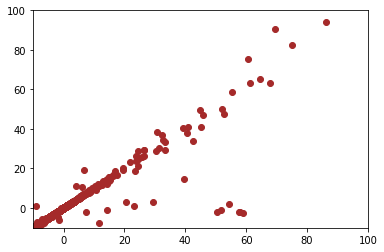

In [124]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=20)
forest.fit(X,y)
forest_pred=forest.predict(X)
forest_test=forest.predict(Xtest)
plt.scatter(forest_test,ytest,c='brown',marker='o')
plt.xlim(-10,100)
plt.ylim(-10,100)

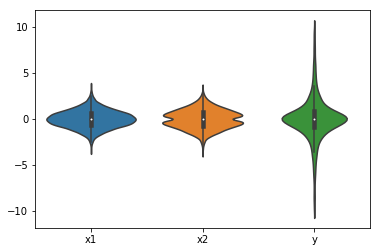

In [248]:
sns.violinplot(data=df[abs(df['y'])<10])

/Users/dyanni3/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


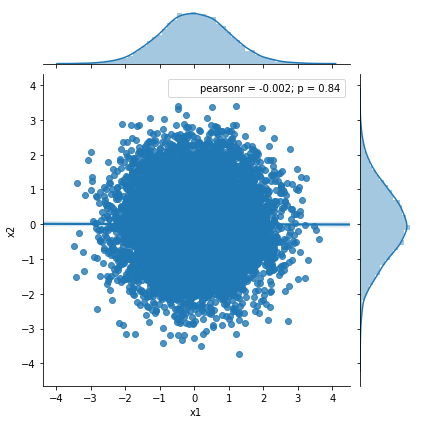

In [252]:
sns.jointplot(x='x1', y='x2', data=df, kind="reg");